In [5]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math
import torch.utils.data as data
import numpy as np
import os
from vocabulary import Vocabulary
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
## TODO #1: Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

In [87]:
# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [2]:
# Build data loader.
data_loader = get_loader(transform=transform_train,
                            mode='train',
                            batch_size=batch_size,
                            vocab_threshold=vocab_threshold,
                            vocab_from_file=False, cocoapi_loc='/workspace/captions')

In [3]:
# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

In [4]:
# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [5]:
# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

In [6]:
# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

In [ ]:
# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

In [ ]:
# Open the training log file.
f = open(log_file, 'w')

#old_time = time.time()
# response = requests.request("GET", 
#                             "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
#                             headers={"Metadata-Flavor":"Google"})
encoder.load_state_dict(torch.load("/workspace/captions/models/encoder-step14400.pkl"))
decoder.load_state_dict(torch.load("/workspace/captions/models/decoder-step14400.pkl"))

In [ ]:
for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        #if time.time() - old_time > 60:
        #    old_time = time.time()
            # requests.request("POST", 
            #                  "https://nebula.udacity.com/api/v1/remote/keep-alive", 
            #                  headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            torch.save(decoder.state_dict(), os.path.join('/workspace/captions/models', 'decoder-step%d.pkl' % i_step))
            torch.save(encoder.state_dict(), os.path.join('/workspace/captions/models', 'encoder-step%d.pkl' % i_step))
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('/workspace/captions/models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('/workspace/captions/models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

In [2]:
def clean_sentence(vocab, output):
    list_string = []
    
    for idx in output:
        list_string.append(vocab.idx2word[idx])
    
    list_string = list_string[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

In [3]:
#prediction
def Captioning(path):
    # TODO #1: Define a transform to pre-process the testing images.
    transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                            transforms.ToTensor(), \
                                            transforms.Normalize((0.485, 0.456, 0.406), \
                                                                (0.229, 0.224, 0.225))])

    # TODO #2: Specify the saved models to load.
    encoder_file = './encoder-step18400.pkl' 
    decoder_file = './decoder-step18400.pkl'

    # TODO #3: Select appropriate values for the Python variables below.
    embed_size = 512
    hidden_size = 512

    annotations_file = 'captions_train2017.json'
    # The size of the vocabulary.
    vocab = Vocabulary(6, "./vocab.pkl", "<start>",
                "<end>", "<unk>", annotations_file, True)
    vocab_size = len(vocab)

    # Initialize the encoder and decoder, and set each to inference mode.
    encoder = EncoderCNN(embed_size)
    encoder.eval()
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
    decoder.eval()

    # Load the trained weights.
    encoder.load_state_dict(torch.load(encoder_file, map_location=torch.device('cpu')))
    decoder.load_state_dict(torch.load(decoder_file, map_location=torch.device('cpu')))

    img = Image.open(path)
    #image = image.to(device)
    img = transform_test(img).unsqueeze(0)

    # Obtain the embedded image features.
    print("image.shape: ", img.shape)
    features = encoder(img).unsqueeze(1)
    print("features.shape: ", features.shape)
    # Pass the embedded image features through the model to get a predicted caption.
    output = decoder.sample(features)
    print('example output:', output)
    assert (type(output)==list), "Output needs to be a Python list" 
    assert all([type(x)==int for x in output]), "Output should be a list of integers." 
    assert all([x in vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."
    sentence = clean_sentence(vocab, output)
    return sentence

Vocabulary successfully loaded from vocab.pkl file!


c:\Users\trong\Downloads\honda_spotweld\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\trong\Downloads\honda_spotweld\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


image.shape:  torch.Size([1, 3, 224, 224])
features.shape:  torch.Size([1, 1, 512])
example output: [0, 3, 152, 123, 243, 330, 475, 3, 410, 123, 618, 12, 1]
A group of people standing around a lot of kites .


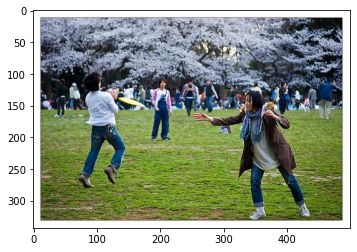

In [7]:
img = np.asarray(Image.open("./5734e1224836b2c8513f2852ddde9a666decc0e5.jpg"))
plt.imshow(img)
print(Captioning("./5734e1224836b2c8513f2852ddde9a666decc0e5.jpg"))